In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df1 = pd.read_csv('bengaluru_house_prices.csv')
df1.head(1)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07


In [7]:
df1.shape

(13320, 9)

In [8]:
df1.groupby('area_type')['area_type'].agg('count')

# ('area_type') -> Makes several dfs on unique area types
# ['area_type'] -> Selects area_type col from dfs created in previous step

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [9]:
df2 = df1.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns')
df2.head(1)

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07


> DATA CLEANING

In [10]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [11]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [12]:
df3.shape

(13246, 5)

In [13]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

> FEATURE ENGINEERING

In [14]:
df3 = df3.assign(bhk=df3['size'].apply(lambda x: int(x.split(' ')[0])))
df3.head(1)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2


In [15]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [16]:
df3['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [17]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [18]:
df3[~df3['total_sqft'].apply(is_float)].head(1)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.0,4


In [19]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens)==2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [20]:
convert_sqft_to_num('2166')

2166.0

In [21]:
convert_sqft_to_num('2100 - 2850')

2475.0

In [22]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
df4.head(1)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2


In [23]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [24]:
df5 = df4.copy()
df5['price_per_sqft'] = (df5['price']*100000) / df5['total_sqft']
df5.head(1)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606


In [25]:
len(df5['location'].unique())

1304

In [26]:
df5.location = df5['location'].apply(lambda x: x.strip())

location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

# x.strip() removes leading & trailing whitespaces

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

> DIMENSIONALITY REDUCTION

In [27]:
len(location_stats[location_stats<=10])

1052

In [28]:
location_stats_lessthan10 = location_stats[location_stats<=10]
location_stats_lessthan10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [29]:
len(df5['location'].unique())

1293

In [30]:
df5['location'] = df5['location'].apply(lambda x: 'other' if x in location_stats_lessthan10 else x)
len(df5['location'].unique())

242

> OUTLIER REMOVAL

In [31]:
df5[df5['total_sqft'] / df5['bhk'] < 300].head(1)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804


In [32]:
df6 = df5[~(df5['total_sqft'] / df5['bhk'] < 300)]
df6.shape

(12502, 7)

In [33]:
df6['price_per_sqft'].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [34]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf['price_per_sqft'])
        st = np.std(subdf['price_per_sqft'])
        reduced_df = subdf[(subdf['price_per_sqft'] > (m-st)) & (subdf['price_per_sqft'] <= (m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [35]:
df7 = remove_pps_outliers(df6)
df7.shape

(10241, 7)

In [36]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df['location']==location) & (df['bhk']==2)]
    bhk3 = df[(df['location']==location) & (df['bhk']==3)]
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, color='green', label='3 BHK', s=50)
    plt.xlabel('Total sqft area')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

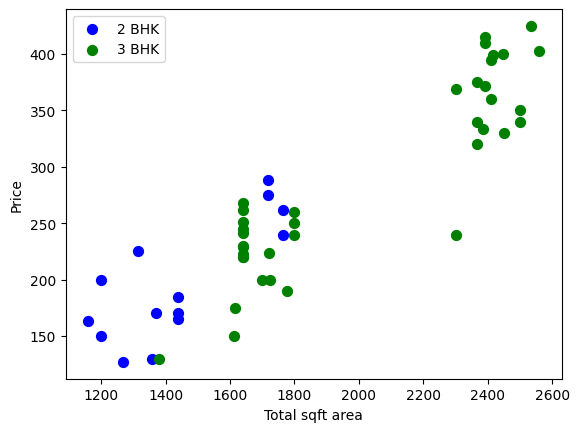

In [37]:
plot_scatter_chart(df7, 'Rajaji Nagar')

In [38]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df['price_per_sqft']),
                'std': np.std(bhk_df['price_per_sqft']),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df['price_per_sqft'] < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

In [39]:
df8 = remove_bhk_outliers(df7)
df8.shape

(7329, 7)

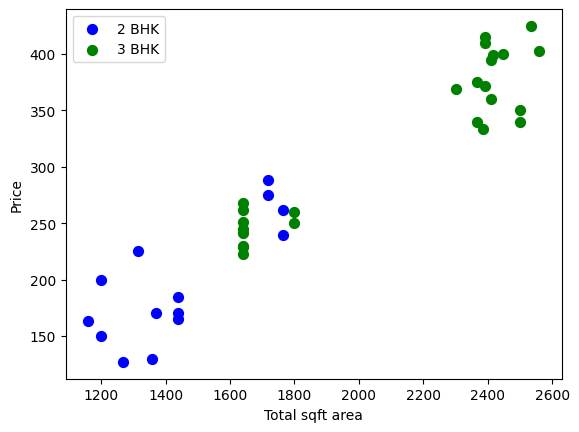

In [40]:
plot_scatter_chart(df8, 'Rajaji Nagar')

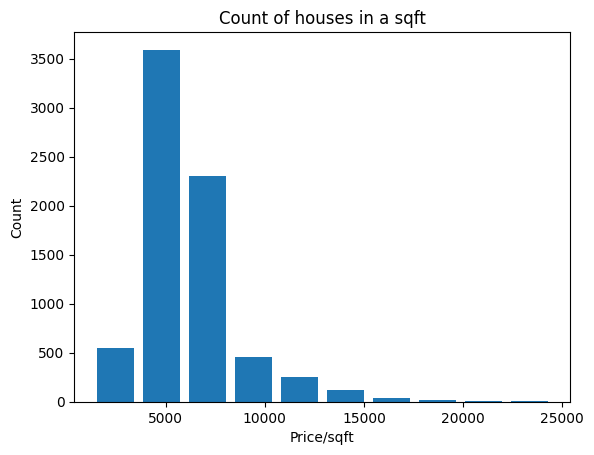

In [41]:
plt.hist(df8['price_per_sqft'], rwidth=0.8)
plt.title('Count of houses in a sqft')
plt.xlabel('Price/sqft')
plt.ylabel('Count')
plt.show()

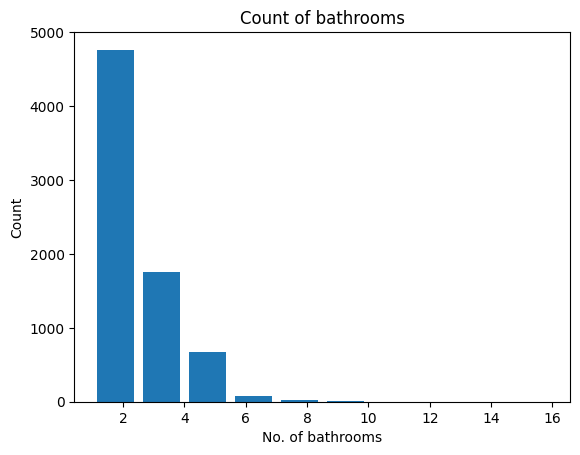

In [42]:
plt.hist(df8['bath'], rwidth=0.8)
plt.title('Count of bathrooms')
plt.xlabel('No. of bathrooms')
plt.ylabel('Count')
plt.show()

In [43]:
df8[df8['bath'] > df8['bhk']+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [44]:
df9 = df8[df8['bath'] < df8['bhk']+2]
df9.shape

(7251, 7)

In [45]:
df10 = df9.drop(['size', 'price_per_sqft'], axis='columns')
df10.shape

(7251, 5)

In [46]:
dummies = pd.get_dummies(df10['location'])
dummies.head(1)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [47]:
df11 = pd.concat([df10, dummies.drop('other', axis='columns')], axis='columns')
df11.head(1)

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [48]:
df12 = df11.drop('location', axis='columns')
df12.head(1)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [49]:
df12.shape

(7251, 245)

In [50]:
X = df12.drop('price', axis='columns')
X.head(1)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [51]:
y = df12['price']
y.head(1)

0    428.0
Name: price, dtype: float64

In [52]:
from sklearn.model_selection import train_test_split as TTS
X_train, X_test, y_train, y_test = TTS(X, y, test_size=0.2, random_state=1)

In [53]:
from sklearn.linear_model import LinearRegression as LR
lr = LR()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8494788916419626

In [54]:
from sklearn.model_selection import ShuffleSplit as SS
from sklearn.model_selection import cross_val_score as CVS
from sklearn.linear_model import LinearRegression as LR

cv = SS(n_splits=5, test_size=0.2, random_state=1)
CVS(LR(), X, y, cv=cv)

array([0.84947889, 0.79977228, 0.81246183, 0.79803073, 0.88172551])

In [55]:
from sklearn.model_selection import GridSearchCV as GSC
from sklearn.linear_model import Lasso as L
from sklearn.tree import DecisionTreeRegressor as DTC

algos = {
    'LR': {'model': LR(), 'params': {'fit_intercept': [True, False]}},
    'Lasso': {'model': L(), 'params': {'alpha': [1, 2], 'selection': ['random', 'cyclic']}},
    'DT': {'model': DTC(), 'params': {'criterion': ['friedman_mse'], 'splitter': ['best', 'random']}}
}

def find_best_model_usingGSC(X, y):
    scores = []
    cv = SS(n_splits=5, test_size=0.2, random_state=0)

    for algo_name, config in algos.items():
        gs = GSC(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({'model': algo_name, 'best_score': gs.best_score_, 'best_params': gs.best_params_})

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

# Now call the function with appropriate X and y
# find_best_model_usingGSC(X, y)


In [56]:
find_best_model_usingGSC(X, y)

,model,best_score,best_params
0,LR,0.819001,{'fit_intercept': False}
1,Lasso,0.687487,"{'alpha': 2, 'selection': 'random'}"
2,DT,0.716745,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [57]:
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
    return lr.predict([x])[0]

In [58]:
predict_price('1st Phase JP Nagar', 1000, 2, 2)

C:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


87.73026323776305

In [59]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr,f)

In [60]:
import json 
columns = {
    'data_columns': [col.lower() for col in X.columns]
}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))